In [47]:
using DrWatson
@quickactivate "Simulation"
include(srcdir("TienGordon.jl"))

import .TienGordon as TG
using CairoMakie
using ProgressMeter

In [48]:
TG.ν = 7.8E9
# TG.extend = true
τ = 0.05
acc = 10
y = collect(0:0.01:4) .* 0.001;

In [49]:
x = TG.V0()

z = Matrix{Float64}(undef, length(x), length(y))
progress = Progress(length(y), 1, "Working...")
for yi in 1:lastindex(y)
    for xi in 1:lastindex(x)
        next!(progress)
        z[xi, yi] = TG.IV₀(x[xi], y[yi], acc, τ)
    end
end

dz = Matrix{Float64}(undef, length(x) - 1, length(y))
for i in 1:lastindex(y)
    dz[:, i] = diff(z[:, i]) ./ diff(x)
end

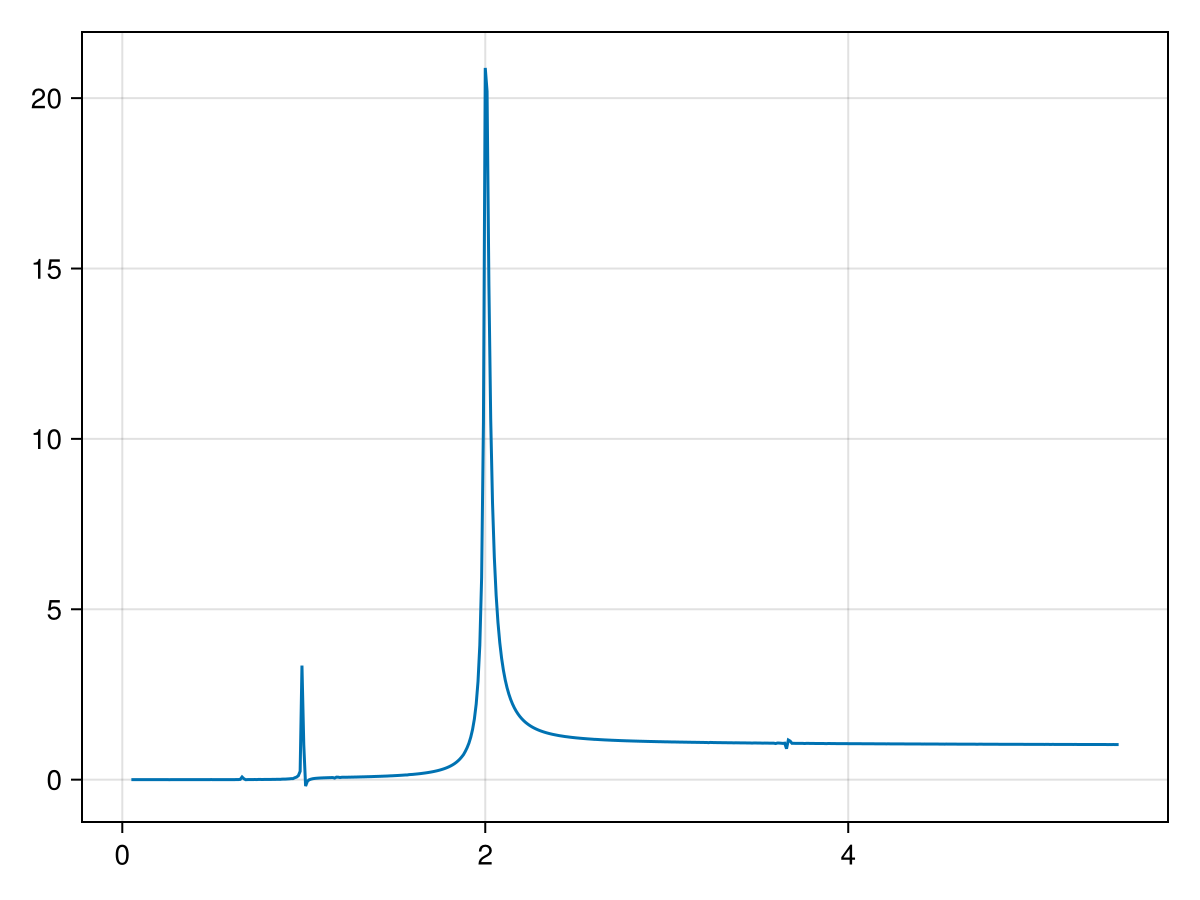

CairoMakie.Screen{IMAGE}


In [50]:
fig = Figure()
ax = Axis(fig[1, 1])

lines!(ax, x[1:end-1], dz[:, 5])
# plt = heatmap!(ax, x[1:end-1], y, dz)
# Colorbar(fig[1, 2], plt)

display(fig)

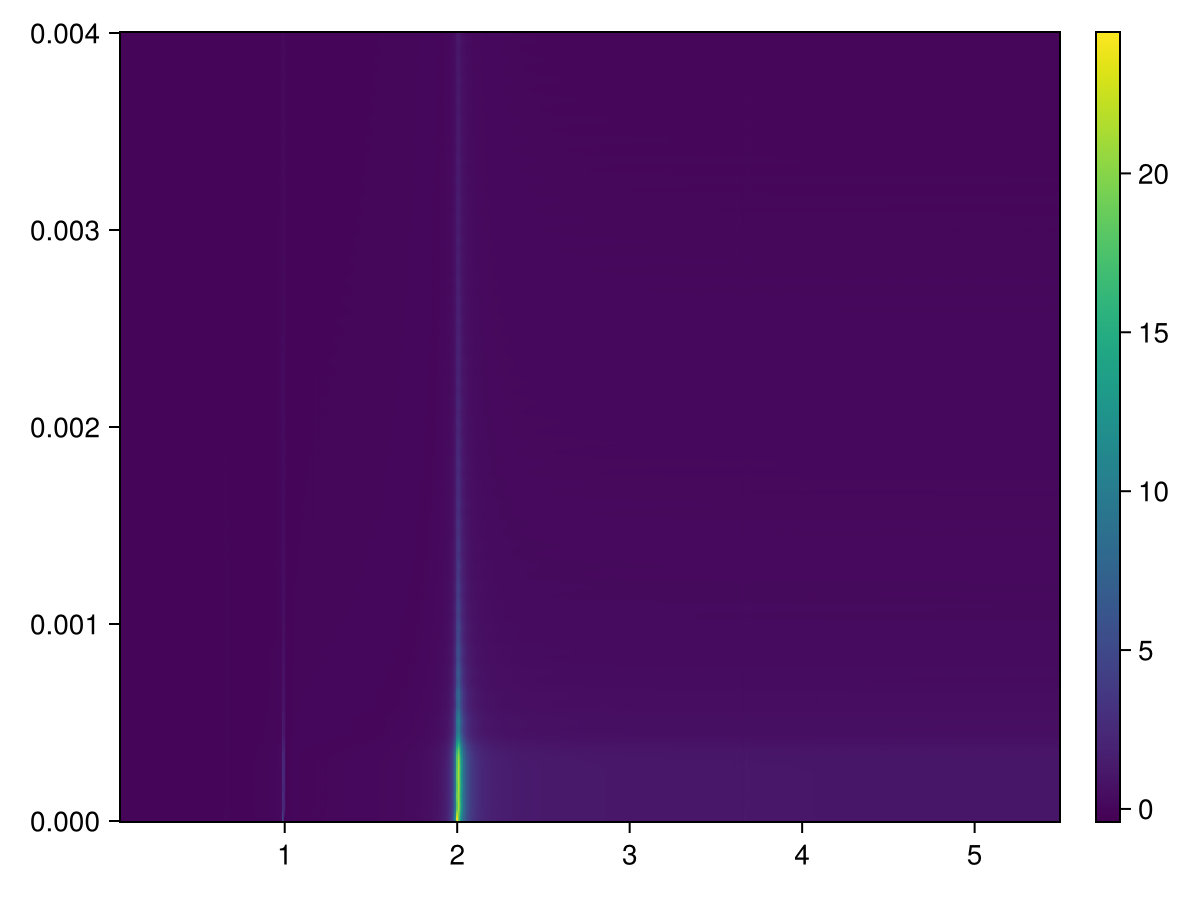

CairoMakie.Screen{IMAGE}


In [51]:
fig = Figure()
ax = Axis(fig[1, 1])

# lines!(ax, x[1:end-1], dz[:, 1])
plt = heatmap!(ax, x[1:end-1], y, dz)
Colorbar(fig[1, 2], plt)

display(fig)